In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("PlantVillage", image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE, shuffle=True)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

Potato___Late_blight


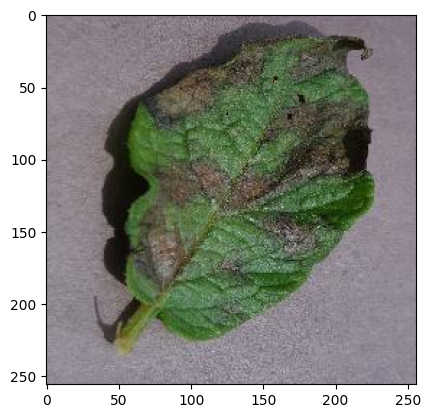

In [6]:
for img, labels in dataset.take(1):
    plt.imshow(img[0].numpy().astype("uint8"))
    print(class_names[labels[0].numpy()])

BUILDING TRAIN AND TEST SET

In [7]:
def developing_train_test_set(ds, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    total_len=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    
    
    train_len=int(total_len*train_size)
    val_len=int(total_len*val_size)
    test_len=int(total_len*test_size)
    
    train_ds=ds.take(train_len)
    val_ds=ds.skip(train_len).take(val_len)
    test_ds=ds.skip(train_len+val_len)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds ,test_ds=developing_train_test_set(dataset)

In [9]:
len(train_ds)

54

In [10]:
len(val_ds)

6

In [11]:
len(test_ds)

8

In [12]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [13]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
input_shape=(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

model=tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(kernel_size=3, filters=32,input_shape=input_shape, activation="relu"),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(kernel_size=3, filters=64, activation="relu"),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(kernel_size=3, filters=64, activation="relu"),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(kernel_size=3, filters=64, activation="relu"),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(kernel_size=3, filters=64, activation="relu"),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=32, activation="relu"),
    layers.Dense(units=3, activation="softmax")
])
model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [18]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

In [ ]:
model.fit(train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 245s 4s/step - loss: 0.8872 - accuracy: 0.4878 - val_loss: 0.7430 - val_accuracy: 0.6458
Epoch 2/50
54/54 [==============================] - 130s 2s/step - loss: 0.6190 - accuracy: 0.7477 - val_loss: 0.4519 - val_accuracy: 0.8385
Epoch 3/50
54/54 [==============================] - 114s 2s/step - loss: 0.3526 - accuracy: 0.8501 - val_loss: 0.3196 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 125s 2s/step - loss: 0.2555 - accuracy: 0.9091 - val_loss: 0.5150 - val_accuracy: 0.7969
Epoch 5/50
54/54 [==============================] - 118s 2s/step - loss: 0.2336 - accuracy: 0.9115 - val_loss: 0.2855 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 127s 2s/step - loss: 0.2059 - accuracy: 0.9213 - val_loss: 0.3163 - val_accuracy: 0.8594
Epoch 7/50
54/54 [==============================] - 136s 3s/step - loss: 0.2048 - accuracy: 0.9172 - val_loss: 0.2430 - val_accuracy: 0.9219
Epoch 8/50
54

In [ ]:
model.evaluate(test_ds)

In [ ]:
def predict(model, img):
    image_array=tf.keras.preprocessing.image.img_to_array(img.numpy())
    image_array=tf.expand_dims(image_array,0)
    
    preds=model.predict(image_array)
    preds_class=class_names[np.argmax(preds[0])]
    confidence=round(np.max(pred[0])*100,2)
    return preds_class, confidence

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        
        